In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from sktime.forecasting.all import *

%matplotlib inline

In [2]:
from sktime import show_versions

show_versions()


System:
    python: 3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\a0866893\AppData\Local\Continuum\anaconda3\envs\sktime\python.exe
   machine: Windows-10-10.0.18362-SP0

Python dependencies:
          pip: 20.3
   setuptools: 49.6.0
      sklearn: 0.23.2
        numpy: 1.19.2
        scipy: 1.5.2
       Cython: 0.29.17
       pandas: 1.1.3
   matplotlib: 3.3.2
       joblib: 0.17.0
        numba: None
     pmdarima: 1.7.1
      tsfresh: None


## Setup

In [3]:
y = load_airline()

In [4]:
y = y[:48]
len(y)

48

In [5]:
window_length = 18  # How much of previous history to use to train
fh = np.arange(1, 13)  # How much to forecast (from 1 to 12 or 1 year)
step_length = 1  # How much to step the sliding window

## Simple temporal split

(48,) 36 12
PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10', '1949-11', '1949-12',
             '1950-01', '1950-02', '1950-03', '1950-04', '1950-05', '1950-06',
             '1950-07', '1950-08', '1950-09', '1950-10', '1950-11', '1950-12',
             '1951-01', '1951-02', '1951-03', '1951-04', '1951-05', '1951-06',
             '1951-07', '1951-08', '1951-09', '1951-10', '1951-11', '1951-12',
             '1952-01', '1952-02', '1952-03', '1952-04', '1952-05', '1952-06',
             '1952-07', '1952-08', '1952-09', '1952-10', '1952-11', '1952-12'],
            dtype='period[M]', name='Period', freq='M')


C:\Users\a0866893\AppData\Local\Continuum\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\a0866893\AppData\Local\Continuum\anaconda3\envs\sktime\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


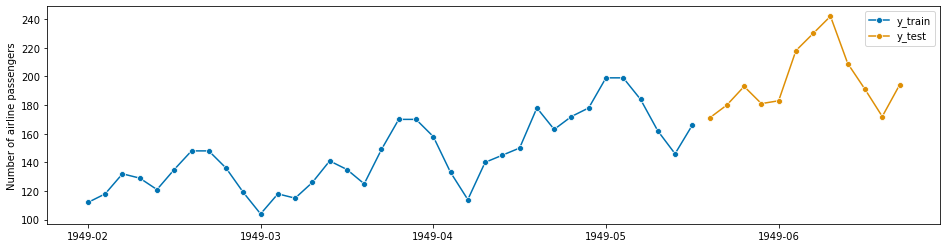

In [6]:
y_train, y_test = temporal_train_test_split(y, test_size=len(fh))
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y.shape, y_train.shape[0], y_test.shape[0])
print(y.index)

## Single Window Splitter

#### Without Window Length Specified

This functions very much like the `temporal_train_test_split` above

In [7]:
cv_single1 = SingleWindowSplitter(fh=fh)

In [8]:
n_splits = cv_single1.get_n_splits(y)
print("-" * 30)
print(f"Number of Folds: {n_splits}")
print("-" * 30)

for i, (train, test) in enumerate(cv_single1.split(y)):
    print(f"\nFold:{i+1}")
    print(f"Train Indices: {train} \nTest Indices:  {test}")

------------------------------
Number of Folds: 1
------------------------------

Fold:1
Train Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 
Test Indices:  [36 37 38 39 40 41 42 43 44 45 46 47]


### With Window Length Specified

In this case, the window length is fixed

In [9]:
cv_single2 = SingleWindowSplitter(window_length=window_length, fh=fh)

In [10]:
n_splits = cv_single2.get_n_splits(y_train)
print("-" * 30)
print(f"Number of Folds: {n_splits}")
print("-" * 30)

for i, (train, test) in enumerate(cv_single2.split(y_train)):
    print(f"\nFold:{i+1}")
    print(f"Train Indices: {train} \nTest Indices:  {test}")

------------------------------
Number of Folds: 1
------------------------------

Fold:1
Train Indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] 
Test Indices:  [24 25 26 27 28 29 30 31 32 33 34 35]


### Cutoff Splitter

* Manually Specify the Cutoff points
* Cutoff indicates the last index of the training data

In [11]:
cv_cutoff1 = CutoffSplitter(
    cutoffs=np.array([12, 15, 18]), window_length=window_length, fh=fh
)

In [12]:
n_splits = cv_cutoff1.get_n_splits(y_train)
print("-" * 30)
print(f"Number of Folds: {n_splits}")
print("-" * 30)

for i, (train, test) in enumerate(cv_cutoff1.split(y_train)):
    print(f"\nFold:{i+1}")
    print(f"Train Indices: {train} \nTest Indices:  {test}")

------------------------------
Number of Folds: 3
------------------------------

Fold:1
Train Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] 
Test Indices:  [13 14 15 16 17 18 19 20 21 22 23 24]

Fold:2
Train Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Test Indices:  [16 17 18 19 20 21 22 23 24 25 26 27]

Fold:3
Train Indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
Test Indices:  [19 20 21 22 23 24 25 26 27 28 29 30]


## Sliding Window Splitter

The code below is a breakdown of the code found in the library for understanding the internal working. 

Refer to **https://github.com/alan-turing-institute/sktime/issues/518** for questions related to this evaluation

In [39]:
help(SlidingWindowSplitter)

Help on class SlidingWindowSplitter in module sktime.forecasting.model_selection._split:

class SlidingWindowSplitter(BaseWindowSplitter)
 |  Sliding window splitter
 |  
 |  Parameters
 |  ----------
 |  fh : int, list or np.array
 |      Forecasting horizon
 |  window_length : int
 |  step_length : int
 |  initial_window : int
 |  start_with_window : bool, optional (default=True)
 |  
 |  Method resolution order:
 |      SlidingWindowSplitter
 |      BaseWindowSplitter
 |      BaseSplitter
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, fh=1, window_length=10, step_length=1, initial_window=None, start_with_window=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_cutoffs(self, y=None)
 |      Get the cutoff time points.
 |      
 |      Parameters
 |      ----------
 |      y : pd.Series or pd.Index, optional (default=None)
 |      
 |      Returns
 |      -------
 |      cutoffs : np.array
 |  
 |  get_n_splits(s

Method resolution order:

    SlidingWindowSplitter
        - Attributes
            - self.step_length
            - self.initial_window
            - self.start_with_window        
        - Methods
            - Other Methods
        
    BaseWindowSplitter
        - Attributes
            - None
        - Methods
            - get_end()
    
    BaseSplitter
        - Attributes
            - self.window_length
            - self.fh            
        - Methods
            - No direct useful ones (some housekeeping, some abstract)
    
    builtins.object

### start_with_window=True

In [14]:
# For training the regressor
initial_window = int(len(y_train) * 0.5)

cv_sliding1 = SlidingWindowSplitter(
    initial_window=initial_window,
    window_length=window_length,
    fh=fh,
    step_length=step_length,
    start_with_window=True,
)

#### Behavior

In [15]:
n_splits = cv_sliding1.get_n_splits(y_train)
print("-" * 30)
print(f"Number of Folds: {n_splits}")
print("-" * 30)

for i, (train, test) in enumerate(cv_sliding1.split(y_train)):
    print(f"\nFold:{i+1}")
    print(f"Train Indices: {train} \nTest Indices:  {test}")

------------------------------
Number of Folds: 7
------------------------------

Fold:1
Train Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] 
Test Indices:  [18 19 20 21 22 23 24 25 26 27 28 29]

Fold:2
Train Indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
Test Indices:  [19 20 21 22 23 24 25 26 27 28 29 30]

Fold:3
Train Indices: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 
Test Indices:  [20 21 22 23 24 25 26 27 28 29 30 31]

Fold:4
Train Indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Test Indices:  [21 22 23 24 25 26 27 28 29 30 31 32]

Fold:5
Train Indices: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
Test Indices:  [22 23 24 25 26 27 28 29 30 31 32 33]

Fold:6
Train Indices: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] 
Test Indices:  [23 24 25 26 27 28 29 30 31 32 33 34]

Fold:7
Train Indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] 
Test Indices:  [24 25 26 27 28 29 30 31 3

#### Initial Split 

In [16]:
# help(cv_sliding1.split_initial)

In [17]:
# Splits the data
# Reserves "Initial Window" for Training and the rest for "Testing"
# According to documentation, forcaster is fit on the train indeices and
# cv is done on test indices
train_indices, test_indices = cv_sliding1.split_initial(y_train)
print(f"Train Indices: {train_indices}\n\nTest Indices: {test_indices}")

Train Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]

Test Indices: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]


#### Sliding Window Splits

In [18]:
end = cv_sliding1._get_end(y_train)
start = cv_sliding1._get_start()
print(f"Start: {start} End: {end}")

Start: 18 End: 25


In [19]:
cutoffs = cv_sliding1.get_cutoffs(y_train)
n_splits = cv_sliding1.get_n_splits(y_train)
print(
    f"Cutoffs: {cutoffs},\nLength of Cutoffs = {len(cutoffs)} = Number of Splits = {n_splits}"
)

Cutoffs: [17 18 19 20 21 22 23],
Length of Cutoffs = 7 = Number of Splits = 7


In [20]:
for split_point in range(start, end, step_length):
    training_window = np.arange(split_point - window_length, split_point)
    test_window = split_point + fh - 1
    print(training_window, test_window)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18 19 20 21 22 23 24 25 26 27 28 29]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19 20 21 22 23 24 25 26 27 28 29 30]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [20 21 22 23 24 25 26 27 28 29 30 31]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] [21 22 23 24 25 26 27 28 29 30 31 32]
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [22 23 24 25 26 27 28 29 30 31 32 33]
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [23 24 25 26 27 28 29 30 31 32 33 34]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] [24 25 26 27 28 29 30 31 32 33 34 35]


### start_with_window=False

In [21]:
# For training the regressor
initial_window = int(len(y_train) * 0.5)

cv_sliding2 = SlidingWindowSplitter(
    initial_window=initial_window,
    window_length=window_length,
    fh=fh,
    step_length=step_length,
    start_with_window=False,
)

#### Behavior

In [22]:
n_splits = cv_sliding2.get_n_splits(y_train)
print("-" * 30)
print(f"Number of Folds: {n_splits}")
print("-" * 30)

for i, (train, test) in enumerate(cv_sliding2.split(y_train)):
    print(f"\nFold:{i+1}")
    print(f"Train Indices: {train} \nTest Indices:  {test}")

------------------------------
Number of Folds: 25
------------------------------

Fold:1
Train Indices: [] 
Test Indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11]

Fold:2
Train Indices: [0] 
Test Indices:  [ 1  2  3  4  5  6  7  8  9 10 11 12]

Fold:3
Train Indices: [0 1] 
Test Indices:  [ 2  3  4  5  6  7  8  9 10 11 12 13]

Fold:4
Train Indices: [0 1 2] 
Test Indices:  [ 3  4  5  6  7  8  9 10 11 12 13 14]

Fold:5
Train Indices: [0 1 2 3] 
Test Indices:  [ 4  5  6  7  8  9 10 11 12 13 14 15]

Fold:6
Train Indices: [0 1 2 3 4] 
Test Indices:  [ 5  6  7  8  9 10 11 12 13 14 15 16]

Fold:7
Train Indices: [0 1 2 3 4 5] 
Test Indices:  [ 6  7  8  9 10 11 12 13 14 15 16 17]

Fold:8
Train Indices: [0 1 2 3 4 5 6] 
Test Indices:  [ 7  8  9 10 11 12 13 14 15 16 17 18]

Fold:9
Train Indices: [0 1 2 3 4 5 6 7] 
Test Indices:  [ 8  9 10 11 12 13 14 15 16 17 18 19]

Fold:10
Train Indices: [0 1 2 3 4 5 6 7 8] 
Test Indices:  [ 9 10 11 12 13 14 15 16 17 18 19 20]

Fold:11
Train Indices: [0 1 2 3 4 5

#### Initial Split

In [23]:
train_indices, test_indices = cv_sliding2.split_initial(y_train)
print(f"Train Indices: {train_indices}\n\nTest Indices: {test_indices}")

Train Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]

Test Indices: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]


#### Sliding Window Splits

In [24]:
end = cv_sliding2._get_end(y_train)
start = cv_sliding2._get_start()
print(f"Start: {start} End: {end}")

Start: 0 End: 25


In [25]:
cutoffs = cv_sliding2.get_cutoffs(y_train)
n_splits = cv_sliding2.get_n_splits(y_train)
print(
    f"Cutoffs: {cutoffs},\nLength of Cutoffs = {len(cutoffs)} = Number of Splits = {n_splits}"
)

Cutoffs: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23],
Length of Cutoffs = 25 = Number of Splits = 25


In [26]:
for split_point in range(start, end, step_length):
    training_window = np.arange(split_point - window_length, split_point)
    test_window = split_point + fh - 1
    print(training_window, test_window)

[-18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1] [ 0  1  2  3  4  5  6  7  8  9 10 11]
[-17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0] [ 1  2  3  4  5  6  7  8  9 10 11 12]
[-16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1] [ 2  3  4  5  6  7  8  9 10 11 12 13]
[-15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2] [ 3  4  5  6  7  8  9 10 11 12 13 14]
[-14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3] [ 4  5  6  7  8  9 10 11 12 13 14 15]
[-13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4] [ 5  6  7  8  9 10 11 12 13 14 15 16]
[-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5] [ 6  7  8  9 10 11 12 13 14 15 16 17]
[-11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6] [ 7  8  9 10 11 12 13 14 15 16 17 18]
[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7] [ 8  9 10 11 12 13 14 15 16 17

### start_with_window=True (Full Values)

In [32]:
# For training the regressor
initial_window = int(len(y_train) * 0.99)  # 0.5

cv_sliding1 = SlidingWindowSplitter(
    initial_window=initial_window,
    window_length=window_length,
    fh=fh,
    step_length=step_length,
    start_with_window=True,
)

#### Behavior

In [33]:
n_splits = cv_sliding1.get_n_splits(y_train)
print("-" * 30)
print(f"Number of Folds: {n_splits}")
print("-" * 30)

for i, (train, test) in enumerate(cv_sliding1.split(y_train)):
    print(f"\nFold:{i+1}")
    print(f"Train Indices: {train} \nTest Indices:  {test}")

------------------------------
Number of Folds: 7
------------------------------

Fold:1
Train Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] 
Test Indices:  [18 19 20 21 22 23 24 25 26 27 28 29]

Fold:2
Train Indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
Test Indices:  [19 20 21 22 23 24 25 26 27 28 29 30]

Fold:3
Train Indices: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 
Test Indices:  [20 21 22 23 24 25 26 27 28 29 30 31]

Fold:4
Train Indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Test Indices:  [21 22 23 24 25 26 27 28 29 30 31 32]

Fold:5
Train Indices: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
Test Indices:  [22 23 24 25 26 27 28 29 30 31 32 33]

Fold:6
Train Indices: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] 
Test Indices:  [23 24 25 26 27 28 29 30 31 32 33 34]

Fold:7
Train Indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] 
Test Indices:  [24 25 26 27 28 29 30 31 3

#### Initial Split 

In [34]:
# help(cv_sliding1.split_initial)

In [35]:
# Splits the data
# Reserves "Initial Window" for Training and the rest for "Testing"
# According to documentation, forcaster is fit on the train indeices and
# cv is done on test indices
train_indices, test_indices = cv_sliding1.split_initial(y_train)
print(f"Train Indices: {train_indices}\n\nTest Indices: {test_indices}")

Train Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]

Test Indices: [35]


#### Sliding Window Splits

In [36]:
end = cv_sliding1._get_end(y_train)
start = cv_sliding1._get_start()
print(f"Start: {start} End: {end}")

Start: 18 End: 25


In [37]:
cutoffs = cv_sliding1.get_cutoffs(y_train)
n_splits = cv_sliding1.get_n_splits(y_train)
print(
    f"Cutoffs: {cutoffs},\nLength of Cutoffs = {len(cutoffs)} = Number of Splits = {n_splits}"
)

Cutoffs: [17 18 19 20 21 22 23],
Length of Cutoffs = 7 = Number of Splits = 7


In [38]:
for split_point in range(start, end, step_length):
    training_window = np.arange(split_point - window_length, split_point)
    test_window = split_point + fh - 1
    print(training_window, test_window)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18 19 20 21 22 23 24 25 26 27 28 29]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19 20 21 22 23 24 25 26 27 28 29 30]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [20 21 22 23 24 25 26 27 28 29 30 31]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] [21 22 23 24 25 26 27 28 29 30 31 32]
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [22 23 24 25 26 27 28 29 30 31 32 33]
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [23 24 25 26 27 28 29 30 31 32 33 34]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] [24 25 26 27 28 29 30 31 32 33 34 35]


In [27]:
# # Some visualization: https://github.com/alan-turing-institute/sktime/issues/477

# from matplotlib.ticker import MaxNLocator

# y = load_airline()[:30]

# window_length = 10
# fh = ForecastingHorizon(np.arange(3))
# fh_length = len(fh)

# cv = SlidingWindowSplitter(window_length=window_length, fh=fh, start_with_window=True)
# n_splits = cv.get_n_splits(y)

# windows = np.empty((n_splits, window_length), dtype=np.int)
# fhs = np.empty((n_splits, fh_length), dtype=np.int)
# for i, (w, f) in enumerate(cv.split(y)):
#     windows[i] = w
#     fhs[i] = f

# fig, ax = plt.subplots(1)

# window_color, fh_color = sns.color_palette("colorblind")[:2]

# def get_y(length, split):
#     return np.ones(length) * split

# for i in range(n_splits):
#     ax.plot(windows[i], get_y(window_length, i), marker="o", c=window_color, label="Window")
#     ax.plot(fhs[i], get_y(fh_length, i), marker="o", c=fh_color, label="Forecasting horizon")

# ax.invert_yaxis()
# ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set(ylabel="Window number", xlabel="Time", xticklabels=y.index);

# # remove duplicate labels/handles
# handles, labels = [(l[:2]) for l in ax.get_legend_handles_labels()]
# # ax.legend(handles, labels)